# Use Case 1 - Basic statistics on time series data

* **Yifan Cheng**, University of Washington
* WaterHackWeek Cyberseminar

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import ulmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# <span style="font-family:Times; fontisize:2.5em;"> Outline </span>
* <span style="font-family:Times; font-size:1.2em;">In previous sections, we covered how to **access data** from different portals. </span> <br/>
* <span style="font-family:Times; font-size:1.2em;">Next, I will cover **basic statistics** and how we calculate it in python through a simple study case on *regulated river temperatures*.</span>  <br/>
    * [<span style="font-family:Times; fontisize:4em;"> 1. Introduction](#1-introduction)
    * [<span style="font-family:Times; fontisize:4em;"> 2. Research Question](#2-question)
    * [<span style="font-family:Times; fontisize:4em;"> 3. Study Area](#3-studyarea)
    * [<span style="font-family:Times; fontisize:4em;"> 4. Data](#4-data)
        * [<span style="font-family:Times; fontisize:4em;"> 4.1. Mapping USGS sites (recap of visualization)](#4.1-datamap)
        * [<span style="font-family:Times; fontisize:4em;"> 4.2. Download USGS data](#4.2-datadownload)
    * [<span style="font-family:Times; fontisize:4em;"> 5. Analysis](#5-analysis)
        * [<span style="font-family:Times;"> 5.1. Time Series Plot](#5.1-timeseries)
        * [<span style="font-family:Times;"> 5.2. Data Selecting and Indexing](#5.2-indexing)
        * [<span style="font-family:Times;"> 5.3. Basic Statistics](#5.3-basicstat)
        * [<span style="font-family:Times;"> 5.4. Data Aggregation (Groupby/Resample)](#5.4-aggregation)
        * [<span style="font-family:Times;"> 5.5. Comprehensive Implementation](#5.5-implement)
</span>        

# <span style="font-family:Times; ">Study case</span>


<a id='1-introduction'></a>
## <span style="font-family:Times; ">1. Introduction</span>
 
* <span style="font-family:Times; fontisize:100;"> **Seasonal thermal stratification** is an important thermal pattern in deep reservoirs. During warm seasons, reservoir will be thermally stratified into a *warmer top layer* - **epilimnion** and a *colder bottom layer* - **hypolimnion**. 
* <span style="font-family:Times; fontisize:100;"> Reservoirs with hypolimnetic releases will have large impacts on downstream river temperatures. </span>

<img src="plot/demo_two_layer.png" alt="drawing" style="width:500px;"/>
<center>Figure 1: Demonstration of thermal stratification</center>

<a id='2-question'></a>
## <span style="font-family:Times; fontisize:2.5em;">2. Research Question</span>
* <span style="font-family:Times; fontisize:10;"> How is reservoir thermal stratification affect downstream river temperature?</span>


<a id='3-studyarea'></a>
## <span style="font-family:Times; fontisize:2.5em;">3. Study Area</span>
* **<span style="font-family:Times; fontisize:10;"> Buford Dam</span>**
    * <span style="font-family:Times; fontisize:10;"> Buford Dam (Lake Lanier) provides hydroelectricity, navigation, and flood control of the Chattahoochee River, and water supply for the city of Atlanta. </span>

<img src="plot/map_buford_reservoir.png" alt="drawing" style="width:500px;"/>
<center>Figure 2: Google map of Buford Reservoir </center>

<a id='4-data'></a>
## <span style="font-family:Times; fontisize:2.5em;">4. Data</span>
* <span style="font-family:Times; fontisize:2.5em;">USGS data
    * One site upstream of Buford Dam: 02333500
    * Four sites downstream of Buford Dam: 02334430, 02334654, 02335000, 02335450 </span>

In [3]:
# selected USGS sites

usgs_site_list=['02333500','02334430','02334654','02335000','02335450']
usgs_color_list=['red','blue','skyblue','yellow','orange']
site_name = ['upstream','downstream-1','downstream-2','downstream-3','downstream-4']

In [4]:
# show selected sites information

ulmo.usgs.nwis.get_sites(sites='02334430')

making request for sites: http://waterservices.usgs.gov/nwis/dv/
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&sites=02334430
making request for sites: http://waterservices.usgs.gov/nwis/iv/
processing data from request: https://waterservices.usgs.gov/nwis/iv/?format=waterml&sites=02334430


{'02334430': {'code': '02334430',
  'name': 'CHATTAHOOCHEE RIVER AT BUFORD DAM, NEAR BUFORD, GA',
  'network': 'NWIS',
  'agency': 'USGS',
  'location': {'latitude': '34.15694444',
   'longitude': '-84.07888889',
   'srs': 'EPSG:4326'},
  'timezone_info': {'uses_dst': True,
   'dst_tz': {'abbreviation': 'EDT', 'offset': '-04:00'},
   'default_tz': {'abbreviation': 'EST', 'offset': '-05:00'}},
  'county': '13135',
  'huc': '03130001',
  'site_type': 'ST',
  'state_code': '13'}}

<a id='4.1-datamap'></a>
### <span style="font-family:Times; fontisize:2.5em;">4.1. Mapping USGS Sites (recap of visualization)</span>

In [5]:
# collect latitude and longitude information
usgs_lat_list=[] # create list of latitude and longitude
usgs_lon_list=[]

for site in usgs_site_list: # loop through all sites
    select_site_info = ulmo.usgs.nwis.get_sites(sites=site)
    usgs_lat_list.append(float(select_site_info[site]['location']['latitude']))
    usgs_lon_list.append(float(select_site_info[site]['location']['longitude']))

making request for sites: http://waterservices.usgs.gov/nwis/dv/
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&sites=02333500
making request for sites: http://waterservices.usgs.gov/nwis/iv/
processing data from request: https://waterservices.usgs.gov/nwis/iv/?format=waterml&sites=02333500
making request for sites: http://waterservices.usgs.gov/nwis/dv/
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&sites=02334430
making request for sites: http://waterservices.usgs.gov/nwis/iv/
processing data from request: https://waterservices.usgs.gov/nwis/iv/?format=waterml&sites=02334430
making request for sites: http://waterservices.usgs.gov/nwis/dv/
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&sites=02334654
making request for sites: http://waterservices.usgs.gov/nwis/iv/
processing data from request: https://waterservices.usgs.gov/nwis/iv/?format=waterml&sites=02334654
making req

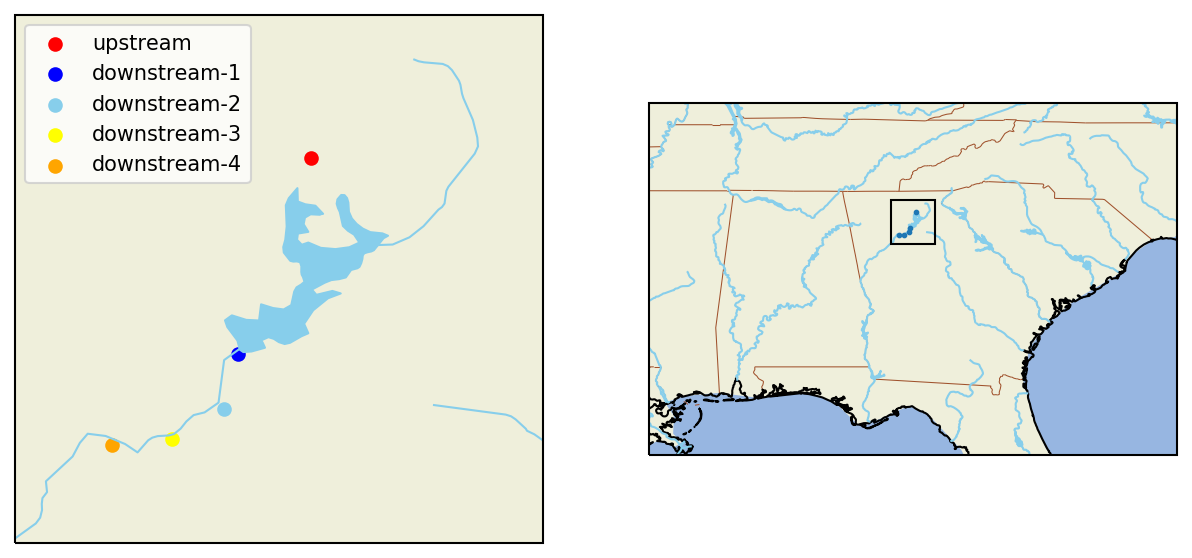

In [6]:
# ========================================= #
#            plot the spatial map           #
# ========================================= #


states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

country_bound = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_0_boundary_lines_land',
                   scale='10m',
                   facecolor='none')

coastline = cfeature.NaturalEarthFeature(
                   category='physical',
                   name='coastline',
                   scale='10m',
                   facecolor='none')

river = cfeature.NaturalEarthFeature(
                   category='physical',
                   name='rivers_lake_centerlines',
                   scale='10m',
                   facecolor='none')

reservoir = cfeature.NaturalEarthFeature(
                   category='physical',
                   name='lakes',
                   scale='10m',
                   facecolor='none')

fig = plt.figure(figsize=(10,5),dpi=150)               # plot size and resolution

# ==============left map================= #
ax0 = plt.subplot(121, projection=ccrs.PlateCarree())  # set projection
ax0.set_extent([-84.5, -83.5, 33.8, 34.8])             # set boundary

# add state boundary, coast line, etc.
ax0.add_feature(states_provinces, edgecolor='sienna', 
                linewidth=0.5, zorder = 1)
ax0.add_feature(coastline, edgecolor='black', 
                zorder = 1)
ax0.add_feature(reservoir,color='skyblue')
ax0.add_feature(river,edgecolor='skyblue', zorder=1)
ax0.add_feature(country_bound, edgecolor='black', 
                zorder = 1)
ax0.add_feature(cfeature.LAND)

# plot the location of selected USGS sites
for i in range(len(usgs_site_list)):
    ax0.scatter(usgs_lon_list[i], usgs_lat_list[i], 
                c=usgs_color_list[i],label=site_name[i])
ax0.legend()

# ==============right map================ #
ax1 = plt.subplot(122, projection=ccrs.PlateCarree())  # set projection
ax1.set_extent([-90, -78, 29, 37])                     # set boundary

# plot the boundary of left map
rect = mp.patches.Rectangle([-84.5,33.8],1,1, zorder=2, 
                            edgecolor='k',facecolor="none")
ax1.add_patch(rect)

# add state boundary, coast line, etc.
ax1.add_feature(states_provinces, edgecolor='sienna', 
                linewidth=0.5, zorder = 1)
ax1.add_feature(coastline, edgecolor='black', 
                zorder = 1)
ax1.add_feature(reservoir,color='skyblue')
ax1.add_feature(river,edgecolor='skyblue', zorder=1)
ax1.add_feature(country_bound, edgecolor='black', 
                zorder = 1)
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)

# plot the location of selected USGS sites
ax1.scatter(usgs_lon_list, usgs_lat_list, s=3, zorder=3)

<a id='4.2-datadownload'></a>
### <span style="font-family:Times;"> 4.2. Download USGS Data
* <span style="font-family:Times;">Use functions from ulmo: *ulmo.usgs.nwis.get_site_data()*
    * site_code: USGS site number (str)
    * parameter_code: Variable code (str) ([Link to all USGS parameter code](https://help.waterdata.usgs.gov/codes-and-parameters/parameters), [Link to USGS parameters commonly used in hydrology](https://help.waterdata.usgs.gov/parameter_cd?group_cd=PHY))
        * 00010: Temperature, water, degrees Celsius
        * 00011: Temperature, water, degrees Fahrenheit
        * 00060: Discharge, cubic feet per second
    * statistic_code: Statistic code (str) ([Link to all USGS statistic code](https://help.waterdata.usgs.gov/stat_code))
        * 00001: Maximum
        * 00002: Minimum
        * 00003: Mean
</span>

In [7]:
# download USGS data using ulmo
param_code = '00010'
stat_code  = '00003'
start_date = '1950-01-01'
end_date   = '2018-12-31'
site_data = ulmo.usgs.nwis.get_site_data(site_code=usgs_site_list[0],parameter_code=param_code, service='daily',
                                         statistic_code=stat_code,start=start_date,end=end_date,
                                         methods="all")

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=02333500&parameterCd=00010&statCd=00003&startDT=1950-01-01&endDT=2018-12-31


In [26]:
site_data

In [9]:
# convert data format to Pandas Dataframe

df = pd.DataFrame(site_data['00010'+':'+
                            '00003']['values'])         # create dataframe
df[usgs_site_list[0]] = df['value'].astype(float)       # convert ['value'] to float
df['date'] = pd.to_datetime(df['datetime'])             # convert ['datetime'] format to date and add as a new column
df.set_index(['date'],inplace=True)                     # set date to be index
df = df.drop(['datetime','value','qualifiers'],axis=1)  # delete column ['datetime']

In [10]:
df.head()

,02333500
date,
2011-10-01,16.7
2011-10-02,14.8
2011-10-03,13.7
2011-10-04,13.7
2011-10-05,14.5


In [11]:
# download data for all sites 

df_sum = pd.DataFrame([])

for i,usgs in enumerate(usgs_site_list):
    # download data
    site_data = ulmo.usgs.nwis.get_site_data(site_code=usgs,parameter_code=param_code, service='daily',
                                             statistic_code=stat_code,start=start_date,end=end_date,
                                             methods="all")
    df = pd.DataFrame(site_data['00010'+':'+
                                '00003']['values'])       # create dataframe
    df[usgs] = df['value'].astype(float)                  # convert ['value'] to float
    df['date'] = pd.to_datetime(df['datetime'])           # convert ['datetime'] format to date and add as a new column
    df.set_index(['date'],inplace=True)                   # set date to be index
    df = df.drop(['datetime','value','qualifiers'],axis=1)             # delete column ['datetime']
    df_sum = pd.concat([df_sum,df], axis=1)

df_sum = df_sum.dropna() # drop the rows with NaN value

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=02333500&parameterCd=00010&statCd=00003&startDT=1950-01-01&endDT=2018-12-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=02334430&parameterCd=00010&statCd=00003&startDT=1950-01-01&endDT=2018-12-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=02334654&parameterCd=00010&statCd=00003&startDT=1950-01-01&endDT=2018-12-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=02335000&parameterCd=00010&statCd=00003&startDT=1950-01-01&endDT=2018-12-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=02335450&parameterCd=00010&statCd=00003&startDT=1950-01-01&endDT=2018-12-31


In [12]:
df_sum.head()

,02333500,02334430,02334654,02335000,02335450
date,,,,,
2015-10-27,13.8,10.9,12.9,13.8,12.9
2015-10-28,13.8,10.7,13.2,14.0,14.1
2015-10-29,14.1,10.6,12.6,13.8,14.2
2015-10-30,13.4,10.5,12.3,13.3,13.5
2015-10-31,12.6,10.2,11.1,11.6,12.5


<a id='5-analysis'></a>
# <span style="font-family:Times; fontisize:4em;"> 5. Analysis

<a id='5.1-timeseries'></a>
## <span style="font-family:Times;"> 5.1. Time Series Plot
* <span style="font-family:Times;">Line plot (*plt.plot(x,y)*)
* <span style="font-family:Times;">Scatter plot (*plt.scatter(x,y)*)
    * recommend scatter plot when data is discontinuous
</span>

Text(0, 0.5, 'stream temp [deg C]')

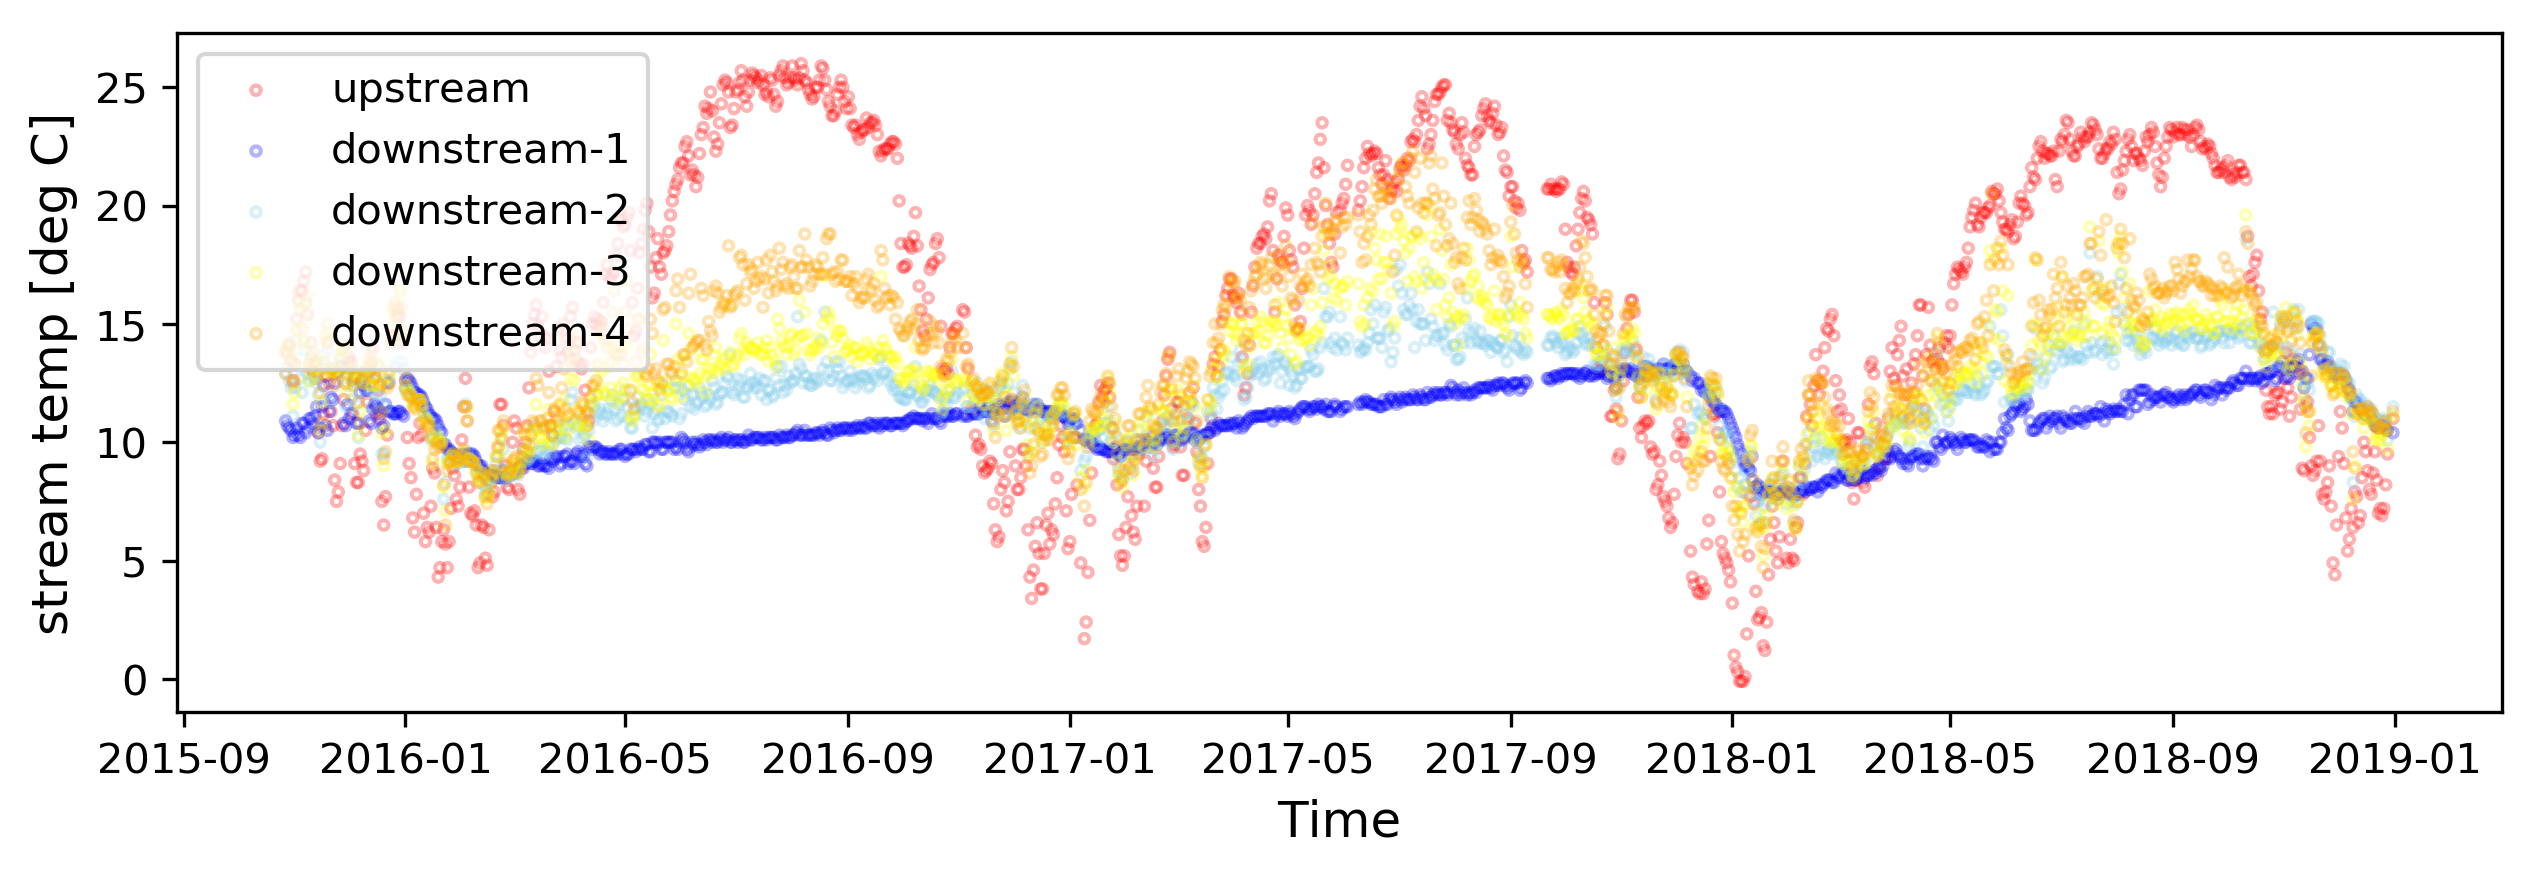

In [13]:
## set figure size and resolution
plt.figure(figsize=[10,3],dpi=300)

for i,usgs in enumerate(usgs_site_list):
    ## scatter plot of all time series data
    plt.scatter(df_sum.index,df_sum[usgs], s=5, 
                edgecolors=usgs_color_list[i],    
                facecolor="none", alpha=0.3, label=site_name[i])
    ## line plot for all time seris data
#     plt.plot(df_sum.index,df_sum[usgs], lw=0.5, 
#              c=usgs_color_list[i],label=usgs)
plt.legend()

plt.xlabel("Time", fontsize=12)
plt.ylabel("stream temp [deg C]", fontsize=12)


<a id='5.2-indexing'></a>
## <span style="font-family:Times; fontisize:4em;"> 5.2. Data Selecting and Indexing
* <span style="font-family:Times;">select column 
    * single column: df["col name"]
    * multiple columns: df[list of column names]
* <span style="font-family:Times;">select index (df.loc[index])
    * single index: df.loc[single date]
    * list of indexes: df.loc[date list]
    * slice of date: df.loc[slice(start date, end date)]

In [14]:
## select single column
temp = df_sum[usgs_site_list[0]]
temp.head()

date
2015-10-27    13.8
2015-10-28    13.8
2015-10-29    14.1
2015-10-30    13.4
2015-10-31    12.6
Name: 02333500, dtype: float64

In [15]:
## select columns
temp = df_sum[usgs_site_list[0:2]]
temp.head()

,02333500,02334430
date,,
2015-10-27,13.8,10.9
2015-10-28,13.8,10.7
2015-10-29,14.1,10.6
2015-10-30,13.4,10.5
2015-10-31,12.6,10.2


In [16]:
## select single index
df.loc['2016-01-01']

02335450    12.7
Name: 2016-01-01 00:00:00, dtype: float64

In [17]:
## select indexes
date_range=pd.date_range('2016-01-01','2016-01-31')
df_sum.loc[date_range]

,02333500,02334430,02334654,02335000,02335450
2016-01-01,12.3,12.6,12.2,12.4,12.7
2016-01-02,10.2,12.7,12.3,12.2,12.0
2016-01-03,9.1,12.6,12.2,12.1,12.0
2016-01-04,8.5,12.5,12.1,12.0,11.9
2016-01-05,6.8,12.3,11.9,11.7,11.5
2016-01-06,6.2,12.1,11.7,11.5,11.4
2016-01-07,7.8,12.1,11.8,11.7,11.6
2016-01-08,10.2,12.0,11.8,11.8,11.8
2016-01-09,10.8,12.0,11.8,11.8,11.8
2016-01-10,10.3,11.9,11.6,11.6,11.5


In [18]:
## select date range
df_sum.loc[slice('2014-01-01','2016-12-31')]

,02333500,02334430,02334654,02335000,02335450
date,,,,,
2015-10-27,13.8,10.9,12.9,13.8,12.9
2015-10-28,13.8,10.7,13.2,14.0,14.1
2015-10-29,14.1,10.6,12.6,13.8,14.2
2015-10-30,13.4,10.5,12.3,13.3,13.5
2015-10-31,12.6,10.2,11.1,11.6,12.5
2015-11-01,13.3,10.3,12.3,12.1,12.6
2015-11-02,15.2,10.6,14.3,14.8,14.7
2015-11-03,16.0,10.3,13.9,15.8,16.3
2015-11-04,16.4,10.2,12.7,14.1,15.6


<a id='5.3-basicstats'></a>
## <span style="font-family:Times;"> 5.3. Basic Statistics
* <span style="font-family:Times;">Metrics:
    * Maximum, Minimum, Mean, Median, Standard Deviation. etc.
* <span style="font-family:Times;">Along row or column: 
    * metric in single column: axis = 0 (e.g., maximum temperature in each site)
    * metric in single row: axis = 1  (e.g., maximum temperature at a specific date)

In [19]:
# maximum temperature at each site
df_sum.median(axis=0)

02333500    15.1
02334430    10.9
02334654    12.3
02335000    13.0
02335450    14.0
dtype: float64

In [20]:
# maximum temperature at a specific date
temp = df_sum.median(axis=1)
temp.head()

date
2015-10-27    12.9
2015-10-28    13.8
2015-10-29    13.8
2015-10-30    13.3
2015-10-31    11.6
dtype: float64

<a id='5.4-aggregation'></a>
## <span style="font-family:Times;"> 5.4. Data Aggregation (Groupby/Resample)
    
* <span style="font-family:Times;"> Resample versus Groupby
    * Resample: upscale the temporal resolution (frequency conversion), e.g., from daily to monthly 
    * Groupby: split whole time series into different groups based on some metric. e.g., same month, same day of year etc., and then combine the results in the same group together
* <span style="font-family:Times;"> Example
    * Calculate mean monthly temperature (Resample)
        * For each month in each year, calculate the mean stream temperature
    * Maximum temperature in June, 2016-2018 (Groupby)
        * For all stream temperature in June throughout all timeseries (June, 2016-2018), find the maximum value
    * Longterm mean monthly temperature (Groupby and Resample together)
        * Calculate mean monthly stream temperature using Resample and calculate the average value for each individual month using groupby

    
    

In [21]:
# calculate mean monthly river temperature
temp = df_sum.resample('M').mean()
temp.head()

,02333500,02334430,02334654,02335000,02335450
date,,,,,
2015-10-31,13.540000,10.580000,12.420000,13.300000,13.440000
2015-11-30,12.536667,11.283333,12.976667,13.423333,13.790000
2015-12-31,11.722581,11.480645,12.561290,12.922581,13.209677
2016-01-31,7.545161,10.974194,10.480645,10.374194,10.270968
2016-02-29,8.255172,8.893103,8.941379,9.079310,9.186207


In [22]:
# calculate maximum river temperature in each month throughout all timeseries
df_sum.groupby(df_sum.index.month).max()

,02333500,02334430,02334654,02335000,02335450
date,,,,,
1,12.5,12.7,12.3,12.7,12.8
2,15.4,10.3,11.6,12.2,13.7
3,16.9,10.8,13.6,15.1,17.0
4,20.5,11.3,13.9,15.9,18.3
5,23.5,11.6,16.5,18.8,20.5
6,25.3,11.9,17.3,18.9,21.1
7,25.9,12.4,18.0,20.0,22.3
8,26.0,12.5,17.1,18.7,20.3
9,24.6,12.9,15.8,18.7,20.0


In [23]:
# calculate longterm mean of monthly mean stream temperature
month_mean = df_sum.resample('M').mean()
longterm_month_mean = month_mean.groupby(month_mean.index.month).mean()
longterm_month_mean

,02333500,02334430,02334654,02335000,02335450
date,,,,,
1,6.638579,9.831053,9.559909,9.410172,9.410284
2,9.484043,8.985400,9.395319,9.751922,10.292404
3,11.549462,9.438710,10.210753,10.639785,11.349462
4,15.302222,10.008889,11.764444,12.772222,14.097778
5,18.710287,10.389032,12.566595,13.923835,15.566237
6,21.734667,10.891111,13.182444,14.588667,16.483111
7,23.726882,11.067742,13.955914,15.653763,18.035484
8,23.311828,11.489247,13.951613,15.258065,17.379570
9,21.768889,11.782222,13.758889,14.876667,16.932222


<a id='5.5-implement'></a>
## <span style="font-family:Times; fontisize:4em;"> 5.5. Comprehensive Implementation

<a id='5.5.1-interannual'></a>
### <span style="font-family:Times; fontisize:4em;"> 5.5.1. Interannual variability

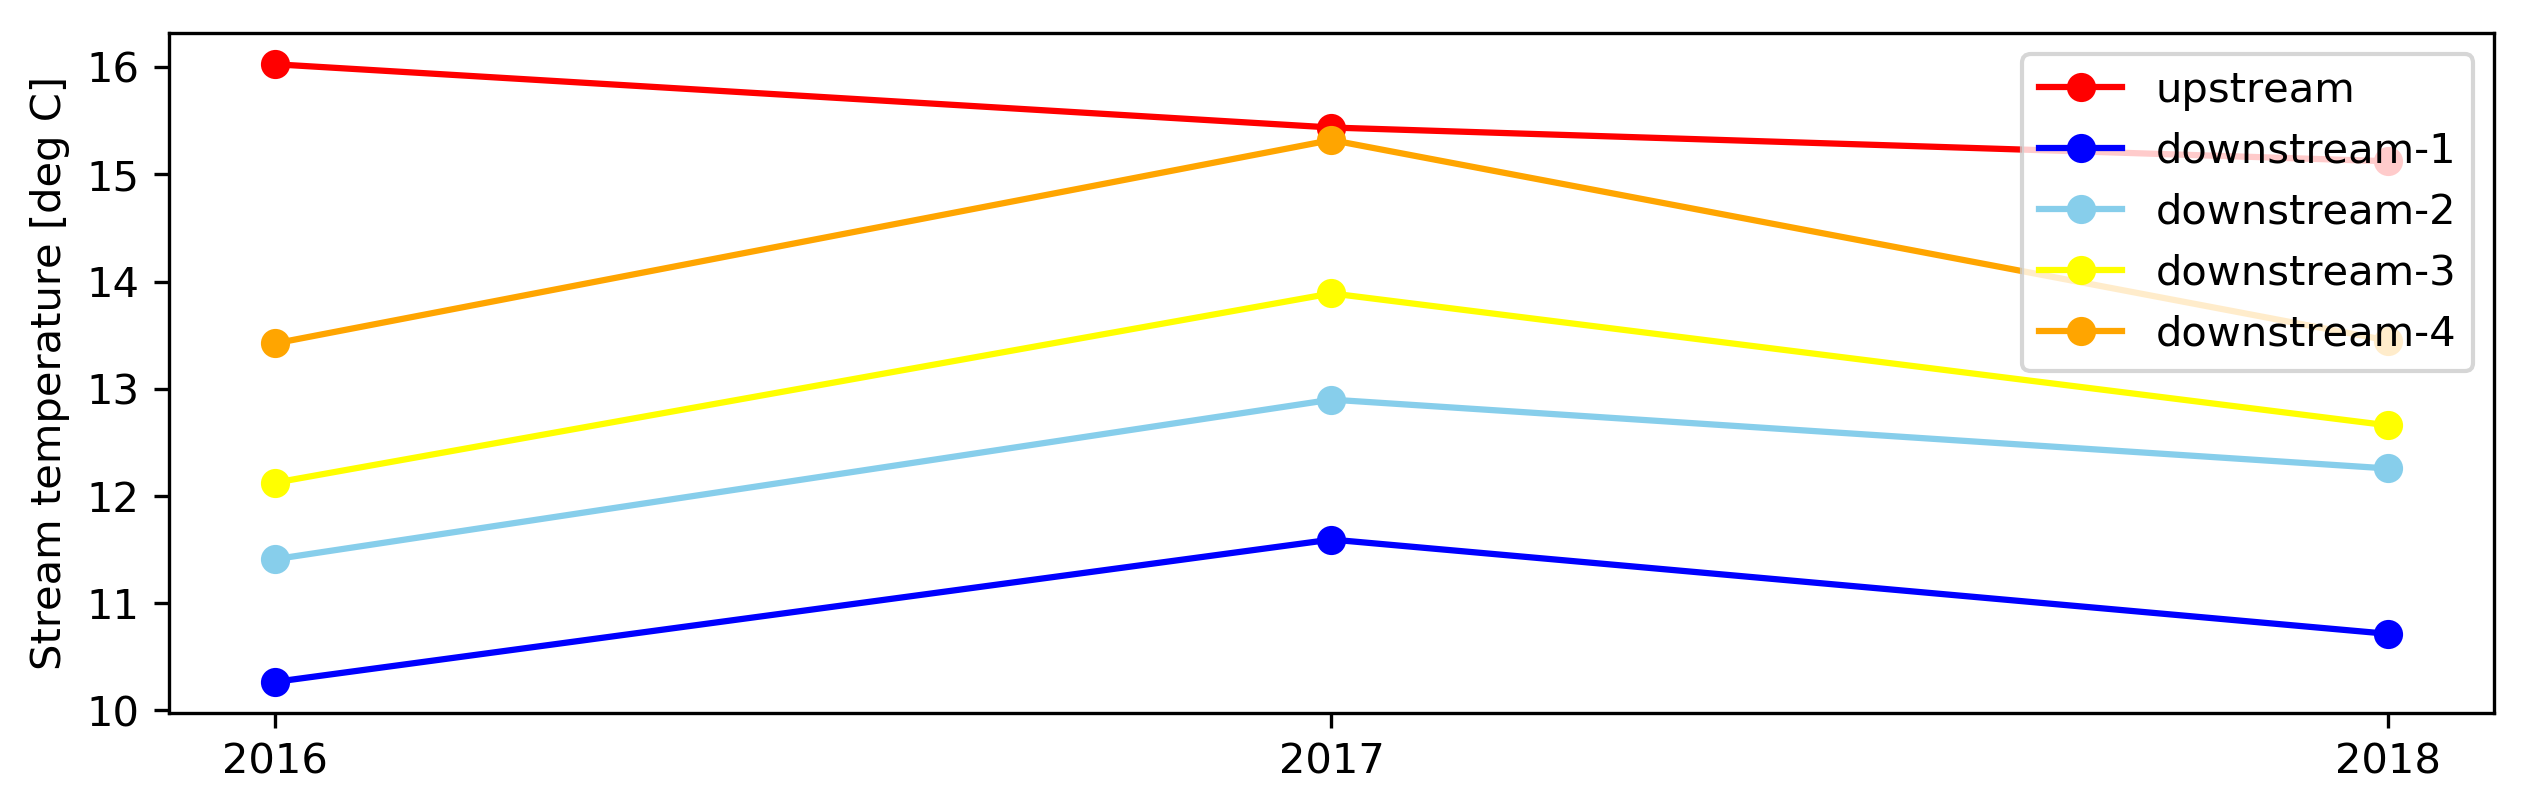

In [24]:
df_sel = df_sum.loc[slice('2016-01-01','2018-12-31')]
annual_mean = df_sel.resample('A').mean()

plt.figure(figsize=[10,3], dpi=300)
for i,usgs in enumerate(usgs_site_list):
    plt.plot(annual_mean.index,annual_mean[usgs],'o-',
             c=usgs_color_list[i], label=site_name[i])
plt.xticks(annual_mean.index,[2016,2017,2018])
plt.ylabel('Stream temperature [deg C]')
plt.legend()

<a id='5.5.2-seasonality'></a>
### <span style="font-family:Times; fontisize:4em;"> 5.5.2. Seasonality

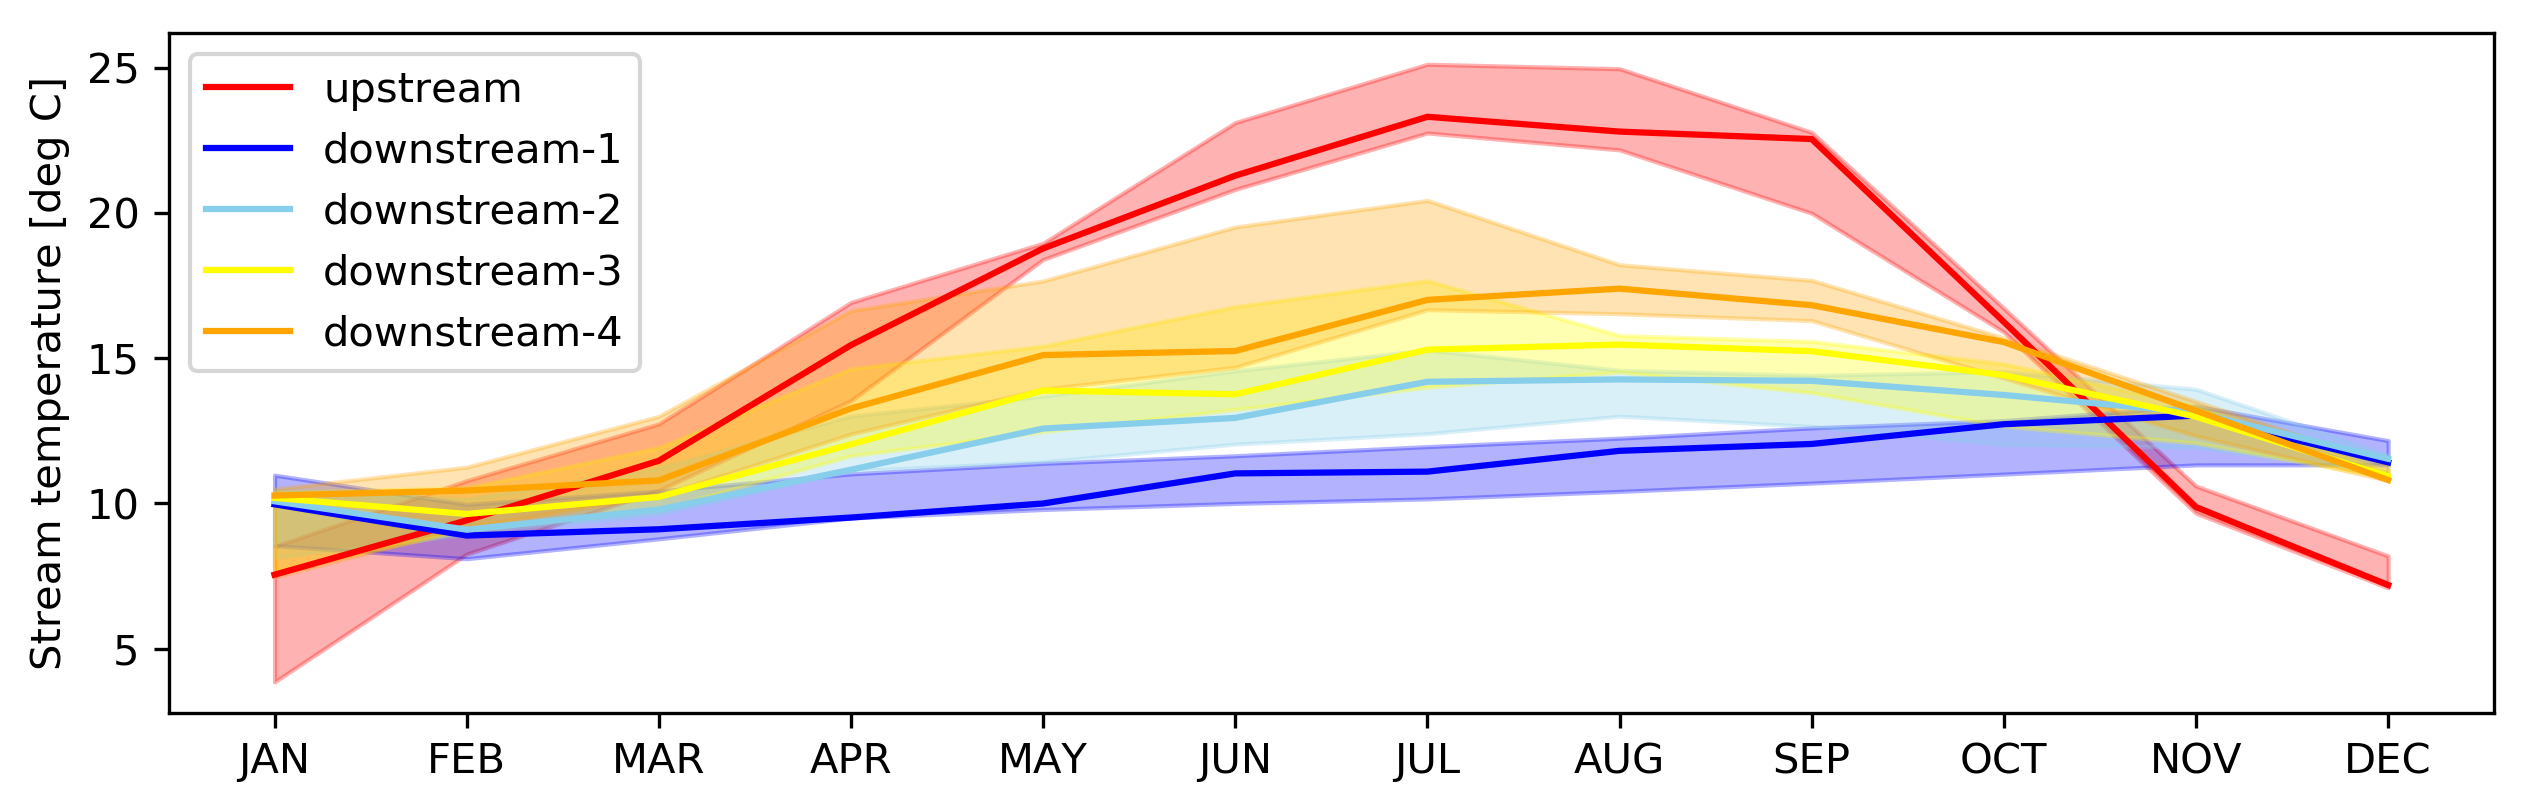

In [25]:
month_mean = df_sel.resample('M').mean()
lg_month_max = month_mean.groupby(month_mean.index.month).max()
lg_month_min = month_mean.groupby(month_mean.index.month).min()
lg_month_median = month_mean.groupby(month_mean.index.month).median()

plt.figure(figsize=[10,3], dpi=300)
for i,usgs in enumerate(usgs_site_list):
    plt.plot(lg_month_median.index,lg_month_median[usgs],'-',
             c=usgs_color_list[i], label=site_name[i])
    plt.fill_between(lg_month_median.index,lg_month_max[usgs],
                     lg_month_min[usgs],color=usgs_color_list[i], alpha=0.3)
plt.xticks(lg_month_median.index,['JAN','FEB','MAR','APR',
                                  'MAY','JUN','JUL','AUG',
                                  'SEP','OCT','NOV','DEC'])
plt.ylabel('Stream temperature [deg C]')
plt.legend()